credit: https://www.kaggle.com/code/ttunjic/gans-for-tabular-data/notebook

https://www.kaggle.com/code/techytushar/tabular-data-generation-using-gans

In [ ]:
!pip install tensorflow
!pip install dask[dataframe]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from tensorflow import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
import keras.backend as K
from sklearn.utils import shuffle

np.random.seed(34)

In [ ]:
class cGAN():
    def __init__(self):
        self.latent_dim = 32
        self.out_shape = 29
        self.num_classes = 2
        self.clip_value = 0.01
        #optimizer = RMSprop(lr=0.00005)

        # build discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=Adam(0.0002, 0.5),
                                   metrics=['accuracy'])

        # build generator
        self.generator = self.build_generator()

        # generating new data samples
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        self.discriminator.trainable = False

        # passing gen samples through disc.
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=Adam(0.0002, 0.5),
                             metrics=['accuracy'])
        self.combined.summary()

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")


    def build_discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, batch_size=32, sample_interval=50):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        global G_losses
        global D_losses

        G_losses = []
        D_losses = []
        for epoch in range(epochs):

            #  Train Discriminator with 8 sample from postivite class and rest with negative class
            idx1 = np.random.choice(pos_index, 8)
            idx0 = np.random.choice(neg_index, batch_size-8)
            idx = np.concatenate((idx1, idx0))
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            # Condition on labels
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            if (epoch+1)%sample_interval==0:
                print (f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if epoch+1==epochs:
                plt.figure(figsize=(10,5))
                plt.title("Generator and Discriminator Loss")
                plt.plot(G_losses,label="G")
                plt.plot(D_losses,label="D")
                plt.xlabel("iterations")
                plt.ylabel("Loss")
                plt.legend()
                plt.show()

In [ ]:
n = 100
df = pd.read_csv('creditcard.csv', encoding='utf-8', sep=',')
df = df.head(int(len(df)*(n/100)))
df = df.drop(columns='Time')


In [ ]:
df.Class.value_counts()

,count
Class,
0,284315
1,492


In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(df.drop(columns='Class'))
y = df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

[LightGBM] [Info] Number of positive: 397, number of negative: 227448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001742 -> initscore=-6.350741
[LightGBM] [Info] Start training from score -6.350741
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56867
           1       0.15      0.64      0.25        95

    accuracy                           0.99     56962
   macro avg       0.58      0.82      0.62     56962
weighted avg       1.00      0.99      1.00     56962



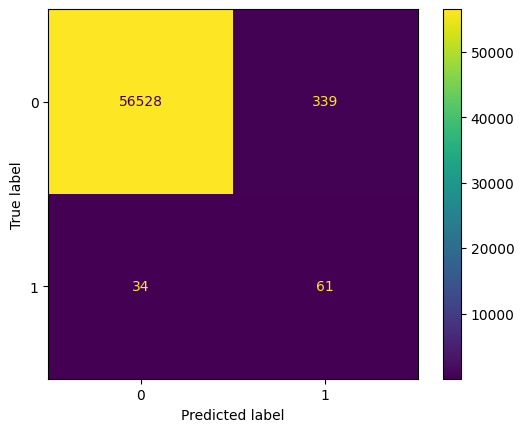

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train, y_train)

y_pred = lgb_1.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(lgb_1, X_test, y_test)
plt.show()

In [ ]:
cgan = cGAN()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │          15,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,713 (702.00 KB)

 Trainable params: 179,713 (702.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 29)                  │          14,877 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 32)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Generator (Functional)    │ (None, 29)             │        187,357 │ input_layer_6[0][0],   │
│                           │                        │                │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Discriminator             │ (None, 1)              │        179,771 │ Generator[0][0],       │
│ (Functional)              │                        │                │ input_layer_7[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 367,128 (1.40 MB)

 Trainable params: 185,565 (724.86 KB)

 Non-trainable params: 181,563 (709.23 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

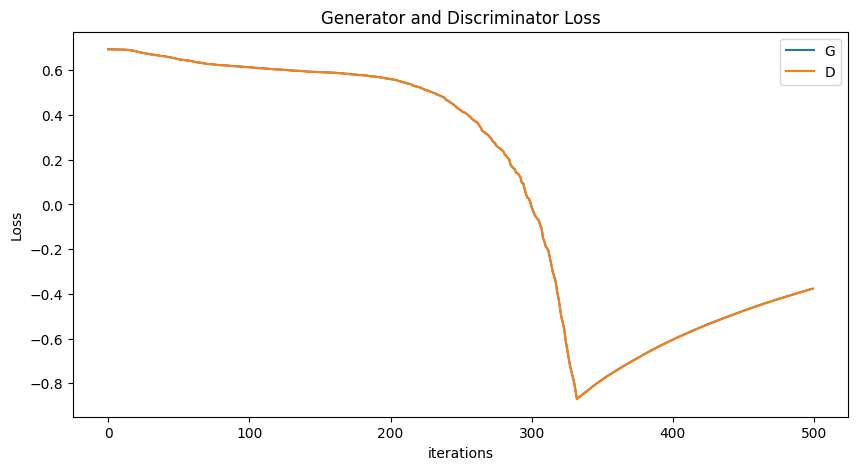

In [ ]:
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train, pos_index, neg_index, epochs=2000, sample_interval=50)

In [ ]:
noise = np.random.normal(0, 1, (227454, 32))
sampled_labels = np.zeros(227454).reshape(-1, 1)


gen_samples = cgan.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop(columns="Class").columns)

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step


In [ ]:
noise_2 = np.random.normal(0, 1, (391, 32))
sampled_labels_2 = np.ones(391).reshape(-1, 1)


gen_samples_2 = cgan.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = df.drop(columns="Class").columns)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
gen_df_2['Class'] = 1
gen_df['Class']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

X_train_2 = df_gan.drop(columns="Class")
y_train_2 = df_gan['Class'].values

[LightGBM] [Info] Number of positive: 391, number of negative: 227454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7393
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001716 -> initscore=-6.365996
[LightGBM] [Info] Start training from score -6.365996
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56867
           1       0.01      0.24      0.01        95

    accuracy                           0.94     56962
   macro avg       0.50      0.59      0.49     56962
weighted avg       1.00      0.94      0.97     56962



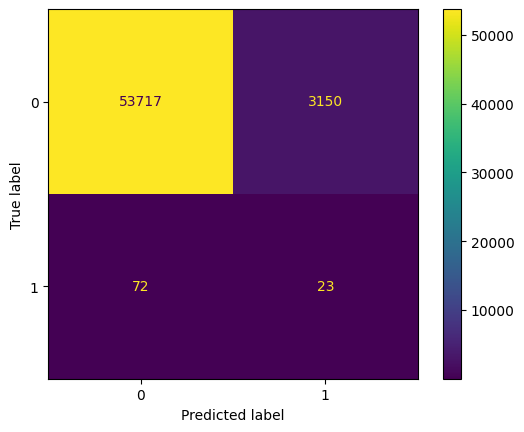

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)


y_pred = lgb_1.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(lgb_1, X_test, y_test)
plt.show()

In [ ]:
noise_3 = np.random.normal(0, 1, (283823, 32))
sampled_labels_3 = np.ones(283823).reshape(-1, 1)


gen_samples_3 = cgan.generator.predict([noise_3, sampled_labels_3])

gen_df_3 = pd.DataFrame(data = gen_samples_3,
                      columns = df.drop(columns="Class").columns)

8870/8870 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


In [ ]:
gen_df_3['Class'] = 1
df_sum = pd.concat([gen_df_3, df], ignore_index=True, sort=False)
df_sum = df_sum.sample(frac=1).reset_index(drop=True)

X_2 = df_sum.drop(columns="Class")
y_2 = df_sum['Class'].values
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_2, y_2, test_size=0.2)

[LightGBM] [Info] Number of positive: 227381, number of negative: 227523
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499844 -> initscore=-0.000624
[LightGBM] [Info] Start training from score -0.000624
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56867
           1       0.12      0.73      0.21        95

    accuracy                           0.99     56962
   macro avg       0.56      0.86      0.60     56962
weighted avg       1.00      0.99      0.99     56962



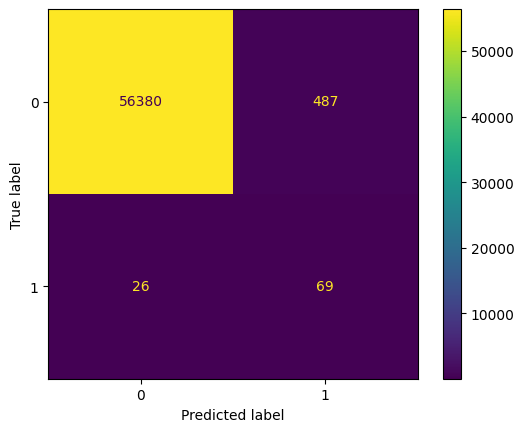

In [ ]:
lgb_2 = lgb.LGBMClassifier()
lgb_2.fit(X_train_3, y_train_3)


y_pred = lgb_2.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(lgb_2, X_test, y_test)
plt.show()